In [1]:
from qiskit import *
from qiskit.result.result import Result, ExperimentResult
from qiskit.providers.aer.noise import *
from qiskit.providers.aer.noise.device import basic_device_noise_model

from qiskit.test.mock import FakeVigo, FakeAthens

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

import numpy as np

import sys
sys.path.append('../')

from qiskit_utilities.utilities import *

from zero_noise_extrapolation_cnot import ZeroNoiseExtrapolation
from zero_noise_extrapolation import mitigate, Richardson_extrapolate

from typing import List

import matplotlib.pyplot as plt
%matplotlib inline

sim_backend = Aer.get_backend("qasm_simulator")
mock_backend = FakeAthens()

In [2]:
def add_swaptest_gate(qc, probe, q1, q2, barrier=False):
    qc.toffoli(probe, q1, q2)
    
    if barrier:
        qc.barrier()
        
    qc.toffoli(probe, q2, q1)
    
    if barrier:
        qc.barrier()
    
    qc.toffoli(probe, q1, q2)
    
def create_3qswaptest_circuit(barrier=False):
    qc = QuantumCircuit(3,1)
    
    qc.h(0)
    
    qc.h(1)
    
    if barrier:
        qc.barrier()
    
    add_swaptest_gate(qc, 0, 1, 2, barrier=barrier)
    
    if barrier:
        qc.barrier()
    
    qc.h(0)
    
    qc.measure(0,0)
    
    return qc

The SWAP-test circuit on two 1-qubit states is constructed as shown belown, using 3 Toffoli-gates (https://arxiv.org/abs/1712.09271).

We prepare the states q_1 = (|0> + |1>)/sqrt(2) and q_2 = |0>, while q_0 is called the probe qubit. The Z-measurement on the probe qubits measures the overlap between the state on q_1 and q_2. The true expectation value in this case is 0.5.

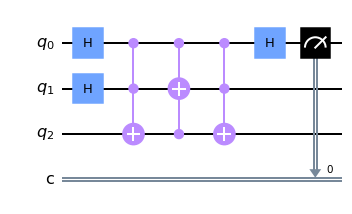

In [3]:
qc = create_3qswaptest_circuit()

qc.draw(output="mpl")

Each Toffoli-gate can be decomposed in the following way. Note that one Toffoli gate has a CNOT complexity of 6. A SWAP-test circuit on two n-qubit states, thus 2n + 1 qubits in total, requires 3n Toffoli gates.

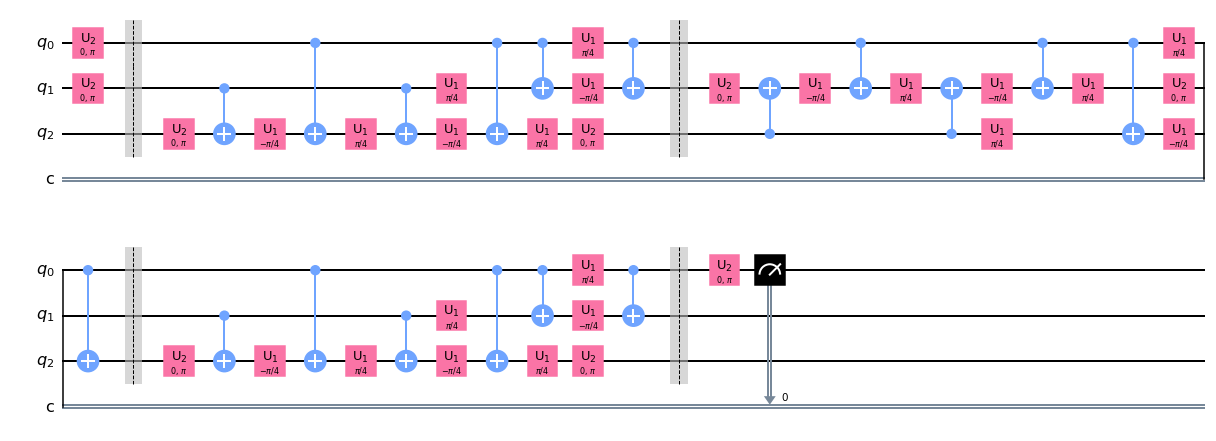

In [4]:
pass_manager = PassManager(Unroller(["u1","u2","u3","cx"]))

qc_swap = create_3qswaptest_circuit(barrier=True)

qc_unrolled = pass_manager.run(qc_swap)

qc_unrolled.draw(output="mpl")

In [5]:
def swaptest_exp_val_func(results: List[ExperimentResult], myfilter=None) -> np.ndarray:
    exp_vals = np.zeros(len(results))
    for i,experiment_result in enumerate(results):
        shots = experiment_result.shots
        counts = experiment_result.data.counts
        eigenval = 0
        for key in counts.keys():
            if key == "0x0":
                eigenval = +1
            elif key == "0x1":
                eigenval = -1
            exp_vals[i] += eigenval*counts[key] / shots
    return exp_vals

Zero noise extrapolation, mitigating noise on CNOT-gates, on the SWAP-test circuit. Executing the circuits on a simulator with a stochastic Pauli noise model. We choose the noise probability on CNOT-gates to be an order of magnitude larger than on the u1/u2/u3 single-qubit gates, which is realistic for modern quantum processors.

Noise amplification factors = [1,3,5,7,9]

In [6]:
p_cnot = 0.01
p_u = 0.001
p_meas = 0.05

bit_flip_cnot = pauli_error([('X',p_cnot),('I',1-p_cnot)])
phase_flip_cnot = pauli_error([('Z',p_cnot),('I',1-p_cnot)])

pauli_error_cnot = bit_flip_cnot.compose(phase_flip_cnot)
cnot_error = pauli_error_cnot.tensor(pauli_error_cnot)

bit_flip_u = pauli_error([('X',p_u),('I',1-p_u)])
phase_flip_u = pauli_error([('Z',p_u),('I',1-p_u)])

pauli_error_u = bit_flip_u.compose(phase_flip_u)

bit_flip_meas = pauli_error([('X',p_meas),('I',1-p_meas)])
phase_flip_meas = pauli_error([('Z',p_meas),('I',1-p_meas)])

pauli_error_meas = bit_flip_u.compose(phase_flip_meas)

NOISE_MODEL = NoiseModel()
NOISE_MODEL.add_all_qubit_quantum_error(cnot_error, ["cx"])
NOISE_MODEL.add_all_qubit_quantum_error(pauli_error_u, ["u2","u3"])
NOISE_MODEL.add_all_qubit_quantum_error(pauli_error_meas, ["measure"])

N_AMP_FACTORS = 7 # -> amplification_factors = [1,3,5,7,9,11,13]
SHOTS = 1024*8192

qem = ZeroNoiseExtrapolation(qc=qc, exp_val_func=swaptest_exp_val_func, backend=sim_backend, noise_model=NOISE_MODEL,
                             n_amp_factors=N_AMP_FACTORS, shots=SHOTS,
                             save_results=True, experiment_name="3qswaptest_paulinoisemodel")

qem.mitigate(verbose=True)

print(qem.result)

Shots per circuit=8388608, executed as 8192 shots per repeat for 1024 experiment repeats.
Pauli twirl=False
Number of noise amplification factors=7
Noise amplification factors=[ 1  3  5  7  9 11 13]
-----
Constructing circuits:
Circuit depths=[ 35.  71. 107. 143. 179. 215. 251.]
-----
Computing expectation values:
Noise amplification factor  1  of  7
Results successfully read from disk.
Noise amplification factor  2  of  7
Results successfully read from disk.
Noise amplification factor  3  of  7
Results successfully read from disk.
Noise amplification factor  4  of  7
Results successfully read from disk.
Noise amplification factor  5  of  7
Results successfully read from disk.
Noise amplification factor  6  of  7
Results successfully read from disk.
Noise amplification factor  7  of  7
Results successfully read from disk.
-----
Error mitigation done
Bare circuit expectation value: 0.25482988357543945
Noise amplified expectation values: [ 2.54829884e-01  6.81722164e-02  1.75709724e-02  

To examine if this method of noise amplification works as expected, we construct a set of noise models where the noise on CNOT-gates is manually ajusted to be amplified by the same set of noise amplification factors. This is done by setting the error rate on the CNOT-gate to p_r = r * p_0, where r is the amplification factor and p_0 the bare error rate. Noise on single-qubit gates and on measurements is kept the same.

Note that this does not represent an actual feasible method of noise amplification as we "amplify" the noise in the very definition of the specific different noise models. But this shall serve as a sanity check for the noise amplification scheme by CNOT repetition. If the scheme amplifies noise as expected we should find the noise amplified expectation value for each amplification factor to align closely with the expectation value found with the corresponding amplified noise model.

In [7]:
amplified_noise_models = []

for amplification_factor in qem.noise_amplification_factors:
    noise_model_temp = NoiseModel()
    
    p_cnot_amplified = amplification_factor * p_cnot
    
    bit_flip_cnot = pauli_error([('X',p_cnot_amplified),('I',1-p_cnot_amplified)])
    phase_flip_cnot = pauli_error([('Z',p_cnot_amplified),('I',1-p_cnot_amplified)])

    pauli_error_cnot = bit_flip_cnot.compose(phase_flip_cnot)
    cnot_error = pauli_error_cnot.tensor(pauli_error_cnot)

    bit_flip_u = pauli_error([('X',p_u),('I',1-p_u)])
    phase_flip_u = pauli_error([('Z',p_u),('I',1-p_u)])

    pauli_error_u = bit_flip_u.compose(phase_flip_u)
    
    bit_flip_meas = pauli_error([('X',p_meas),('I',1-p_meas)])
    phase_flip_meas = pauli_error([('Z',p_meas),('I',1-p_meas)])

    pauli_error_meas = bit_flip_u.compose(phase_flip_meas)
    
    noise_model_temp.add_all_qubit_quantum_error(cnot_error, ["cx"])
    noise_model_temp.add_all_qubit_quantum_error(pauli_error_u, ["u2","u3"])
    noise_model_temp.add_all_qubit_quantum_error(pauli_error_meas, ["measure"])
    
    amplified_noise_models.append(noise_model_temp)

noisemodels_amplified_exp_vals = np.zeros(np.shape(amplified_noise_models)[0])

repeats = qem.repeats
shots = qem.shots

for i, nm in enumerate(amplified_noise_models):
    exp_vals_temp = np.zeros(repeats)
    for j in range(repeats):
        job = execute(qem.qc, sim_backend, shots=shots, noise_model=nm)
        exp_vals_temp[j] = swaptest_exp_val_func(job.result().results)
    noisemodels_amplified_exp_vals[i] = np.average(exp_vals_temp)

Plotting the noise amplified expectation values against each other, we find exactly what we expected. The noise amplification scheme by CNOT repetition seems to amplify the noise present in CNOT-gates very closely to the desired amplification factor.

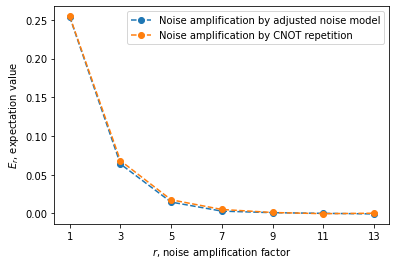

In [8]:
x = qem.noise_amplification_factors

plt.xlabel(r"$r$, noise amplification factor")
plt.ylabel(r"$E_r$, expectation value")

plt.xticks(qem.noise_amplification_factors)

plt.plot(x, noisemodels_amplified_exp_vals,'--o', label="Noise amplification by adjusted noise model")
plt.plot(x, qem.noise_amplified_exp_vals,'--o', label="Noise amplification by CNOT repetition")

plt.legend()

plt.show()

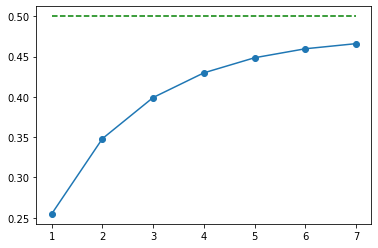

In [9]:
n_amp_factors = qem.n_amp_factors
noise_amplified_exp_vals = qem.noise_amplified_exp_vals
noise_amplification_factors = qem.noise_amplification_factors

mitigated_exp_vals = np.zeros(n_amp_factors)
mitigated_exp_vals[0] = noise_amplified_exp_vals[0]

for n in range(1, n_amp_factors):
    mitigated_exp_vals[n] = Richardson_extrapolate(noise_amplified_exp_vals[0:n+1], noise_amplification_factors[0:n+1])[0]
    
x = [i+1 for i in range(n_amp_factors)]
ideal_exp_val = [0.5 for i in range(n_amp_factors)]

plt.plot(x, ideal_exp_val, '--g')
plt.plot(x, mitigated_exp_vals, '-o')

plt.show()

Zero noise extrapolation, mitigating noise on CNOT-gates, on the SWAP-test circuit. Now on the mock backend FakeVigo, which emulates IBMQ's Vigo quantum device.

Noise amplification factors = [1,3,5,7,9]

In [10]:
#load IBMQ account
#IBMQ.save_account('Your IBMQ token')
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q")

athens_backend = provider.get_backend("ibmq_athens")

athens_noise_model = NoiseModel.from_backend(athens_backend)

C:\Users\ander\.conda\envs\qcomp\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [16]:
N_AMP_FACTORS = 7 # -> amplification_factors = [1,3,5,7,9,11,13]
SHOTS = 2048*8192

qc_transpiled = transpile(qc, athens_backend, optimization_level=3)

qem = ZeroNoiseExtrapolation(qc=qc_transpiled, exp_val_func=swaptest_exp_val_func, backend=sim_backend, 
                             noise_model = athens_noise_model,
                             n_amp_factors=N_AMP_FACTORS, shots=SHOTS,
                             save_results=True, experiment_name="3qswaptest_ibmqathensnoisemodel")

qem.mitigate(verbose=True)

print(qem.result)

Shots per circuit=16777216, executed as 8192 shots per repeat for 2048 experiment repeats.
Pauli twirl=False
Number of noise amplification factors=7
Noise amplification factors=[ 1  3  5  7  9 11 13]
-----
Constructing circuits:
Circuit depths=[ 54. 106. 158. 210. 262. 314. 366.]
-----
Computing expectation values:
Noise amplification factor  1  of  7
Tried to read results from disk, but results were not found.
Executing circuit.
Results successfully written to disk.
Noise amplification factor  2  of  7
Tried to read results from disk, but results were not found.
Executing circuit.
Results successfully written to disk.
Noise amplification factor  3  of  7
Tried to read results from disk, but results were not found.
Executing circuit.
Results successfully written to disk.
Noise amplification factor  4  of  7
Tried to read results from disk, but results were not found.
Executing circuit.
Results successfully written to disk.
Noise amplification factor  5  of  7
Tried to read results from

In [12]:
#load IBMQ account
#IBMQ.save_account('Your IBMQ token')
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q")

ibmqfactory.load_account:WARNING:2021-02-18 17:45:45,912: Credentials are already in use. The existing account in the session will be replaced.


In [19]:
two_qubit_error_map = get_cx_error_map(athens_backend)
athens_basis_gates = athens_noise_model.basis_gates

# we take the same transpiled circuit as used before, because there is some randomness involved in the transpilation
qc_transpiled = qem.qc

n_amp_factors = qem.n_amp_factors

# amplification factors as multiples of 2 seems to give better results for this method
amplification_factors_powersoftwo = [2**i for i in range(n_amp_factors)]

R,E_dict,E_av_dict,\
max_depth_dict,mean_depth_dict,\
max_depth_transpiled_dict,mean_depth_transpiled_dict,\
bn= mitigate(qc_transpiled, amplification_factors_powersoftwo,\
             swaptest_exp_val_func,\
             sim_backend, \
             "3qswaptest_ibmqathens", two_qubit_error_map,\
             8192, 2048,\
             athens_backend,\
             athens_noise_model,\
             athens_basis_gates,\
             paulitwirling=False
             )

print(R[-1])

Sanity checks passed
Result for job ' 3qswaptest_ibmqathens_backendqasm_simulator_noisemodelibmq_athens_shots8192_experiments2048_paulitwirlingFalse_r1 ' successfully read from disk
Result for job ' 3qswaptest_ibmqathens_backendqasm_simulator_noisemodelibmq_athens_shots8192_experiments2048_paulitwirlingFalse_r2 ' successfully read from disk
Result for job ' 3qswaptest_ibmqathens_backendqasm_simulator_noisemodelibmq_athens_shots8192_experiments2048_paulitwirlingFalse_r4 ' successfully read from disk
Result for job ' 3qswaptest_ibmqathens_backendqasm_simulator_noisemodelibmq_athens_shots8192_experiments2048_paulitwirlingFalse_r8 ' successfully read from disk
Result for job ' 3qswaptest_ibmqathens_backendqasm_simulator_noisemodelibmq_athens_shots8192_experiments2048_paulitwirlingFalse_r16 ' successfully read from disk
Result for job ' 3qswaptest_ibmqathens_backendqasm_simulator_noisemodelibmq_athens_shots8192_experiments2048_paulitwirlingFalse_r32 ' successfully read from disk
Result for 

(2048, 1) (2048,) (2048,)
CNOT repetition, mitigated exp vals: [0.3687619  0.45255911 0.48278162 0.49497919 0.50050745 0.50350798
 0.50547507]
Random pauli gates, mitigated exp vals: [0.35229707 0.44469678 0.46557514 0.47000273 0.47081003 0.47087621
 0.47089674]


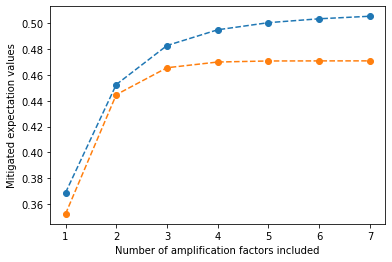

In [20]:
# Process results from ZNE with noise amplification by CNOT repetition:
n_amp_factors = qem.n_amp_factors
noise_amplified_exp_vals = qem.noise_amplified_exp_vals
noise_amplification_factors = qem.noise_amplification_factors

mitigated_exp_vals = np.zeros(n_amp_factors)
mitigated_exp_vals[0] = noise_amplified_exp_vals[0]

for n in range(1, n_amp_factors):
    mitigated_exp_vals[n] = Richardson_extrapolate(noise_amplified_exp_vals[0:n+1], noise_amplification_factors[0:n+1])[0]

print(np.shape(R), np.shape(E_dict[bn + "_r1"]), np.shape(E_av_dict[bn + "_r1"]))
    
print("CNOT repetition, mitigated exp vals:", mitigated_exp_vals)

# Process results from ZNE with noise amplification by random pauli gates:
noise_amplified_exp_vals_randompauliamplification = np.zeros(N_AMP_FACTORS)
mitigated_exp_vals_randompauliamplification = np.zeros(N_AMP_FACTORS)
for i,r in enumerate(amplification_factors_powersoftwo):
    noise_amplified_exp_vals_randompauliamplification[i] = E_av_dict[bn + "_r{:}".format(r)][-1]

mitigated_exp_vals_randompauliamplification[0] = noise_amplified_exp_vals_randompauliamplification[0]

for i in range(1, N_AMP_FACTORS):
    mitigated_exp_vals_randompauliamplification[i] = Richardson_extrapolate(noise_amplified_exp_vals_randompauliamplification[0:i+1],
                                                                            np.asarray(amplification_factors_powersoftwo[0:i+1]))[0]


print("Random pauli gates, mitigated exp vals:", mitigated_exp_vals_randompauliamplification)
    
# Plotting
x = [i+1 for i in range(N_AMP_FACTORS)]

plt.xlabel("Number of amplification factors included")
plt.ylabel("Mitigated expectation values")

plt.plot(x, mitigated_exp_vals, "--o", label="Noise amplification by CNOT repetition")
plt.plot(x, mitigated_exp_vals_randompauliamplification, "--o", label="Noise amplification by random pauli gates")

plt.show()

In [15]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.0',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.23.0'}